# BUDT 737 Big Data and AI for Business
## Final Project
### Team 1

All the sources and references have been documented in the report.

#### importing packages

In [ ]:
# Importing libraries

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

from collections import Counter
import re
import pickle

import plotly
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import plotly.offline
plotly.offline.init_notebook_mode()
from plotly.offline import iplot
from plotly import graph_objs

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text.tsne import tsne
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob, Word


In [ ]:
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
import nltk.corpus
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

#### Mount Google Drive and Read Datasets

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [ ]:
# sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/737project/nlp-getting-started/sample_submission.csv')
# test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/737project/nlp-getting-started/test.csv')
# train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/737project/nlp-getting-started/train.csv')

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

In [ ]:
df2 = train_df.copy()
df3 = test_df.copy()
df2.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

#### EDA and Data Cleaning


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
train_df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [ ]:
# count the number of words
def num_of_words(df, col):
    df['word_ct'] = df[col].apply(lambda x: len(str(x).split(" ")))
    print(df[[col, 'word_ct']])

num_of_words(df2, 'text')
num_of_words(df3, 'text')

                                                   text  word_ct
0     Our Deeds are the Reason of this #earthquake M...       13
1                Forest fire near La Ronge Sask. Canada        7
2     All residents asked to 'shelter in place' are ...       22
3     13,000 people receive #wildfires evacuation or...        9
4     Just got sent this photo from Ruby #Alaska as ...       17
...                                                 ...      ...
7608  Two giant cranes holding a bridge collapse int...       11
7609  @aria_ahrary @TheTawniest The out of control w...       20
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...        8
7611  Police investigating after an e-bike collided ...       19
7612  The Latest: More Homes Razed by Northern Calif...       13

[7613 rows x 2 columns]
                                                   text  word_ct
0                    Just happened a terrible car crash        6
1     Heard about #earthquake is different cities, s...        9


In [ ]:
# collect and remove the special characters
def collect_and_remove_charef(df, col):
    df['charref'] = df[col].apply(lambda x: re.findall(r'&[\S]+?;', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'&[\S]+?;', '', str(x)))
    df.charref = df.charref.apply(lambda x: str(x)[1:-1])

collect_and_remove_charef(df2, 'text')
collect_and_remove_charef(df3, 'text')

In [ ]:
# collect and remove the links start with 'http' and 'bit'
def collect_and_remove_links(df, col):
    df['links_http'] = df[col].apply(lambda x: re.findall(r'http\S+', str(x))) 
    df[col] = df[col].apply(lambda x: re.sub(r'http\S+', '', str(x)))  # remove http links
    df['links_bitly'] = df[col].apply(lambda x: re.findall(r'bit.ly/\S+', str(x))) 
    df[col] = df[col].apply(lambda x: re.sub(r'bit.ly/\S+', '', str(x)))  # remove bit.ly links    
    df.links_http = df.links_http.apply(lambda x: str(x)[1:-1]) # remove brackets around list
    df.links_bitly = df.links_bitly.apply(lambda x: str(x)[1:-1]) # remove brackets around list

collect_and_remove_links(df2, "text")
collect_and_remove_charef(df3, 'text')

In [ ]:
# remove punctuations
def remove_punctuation(df, col):    
    df[col] = df[col].apply(lambda x: re.sub(r'[^\w\s]', r'', str(x)))

remove_punctuation(df2, 'text')
remove_punctuation(df3,'text')

In [ ]:
# lower casing
def lowercasing(df, col):
    df[col] = df[col].apply(lambda x: " ".join(x.lower() for x in x.split()))

lowercasing(df2, 'text')
lowercasing(df3, 'text')

In [ ]:
# remove whitespaces
def remove_whitespaces(df, col):
    df[col] = df[col].apply(lambda x: re.sub(r'\s\s+', ' ', str(x))) # remove any double or more whitespaces to single whitespaces
    df[col] = df[col].apply(lambda x: re.sub(r'(\A\s+|\s+\Z)', '', str(x))) # remove any leading and trailing whitespace

remove_whitespaces(df2, 'text')
remove_whitespaces(df3, 'text')

In [ ]:
print("Before cleaning: ","\n",train_df.text[0:10])

Before cleaning:  
 0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object


In [ ]:
print("After cleaning: ","\n",df2.text[0:10])

After cleaning:  
 0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
5    rockyfire update california hwy 20 closed in b...
6    flood disaster heavy rain causes flash floodin...
7    im on top of the hill and i can see a fire in ...
8    theres an emergency evacuation happening now i...
9     im afraid that the tornado is coming to our area
Name: text, dtype: object


                                                   text  word_ct
0     our deeds are the reason of this earthquake ma...       13
1                 forest fire near la ronge sask canada        7
2     all residents asked to shelter in place are be...       22
3     13000 people receive wildfires evacuation orde...        8
4     just got sent this photo from ruby alaska as s...       16
...                                                 ...      ...
7608  two giant cranes holding a bridge collapse int...       10
7609  aria_ahrary thetawniest the out of control wil...       20
7610               m194 0104 utc5km s of volcano hawaii        7
7611  police investigating after an ebike collided w...       19
7612  the latest more homes razed by northern califo...       11

[7613 rows x 2 columns]


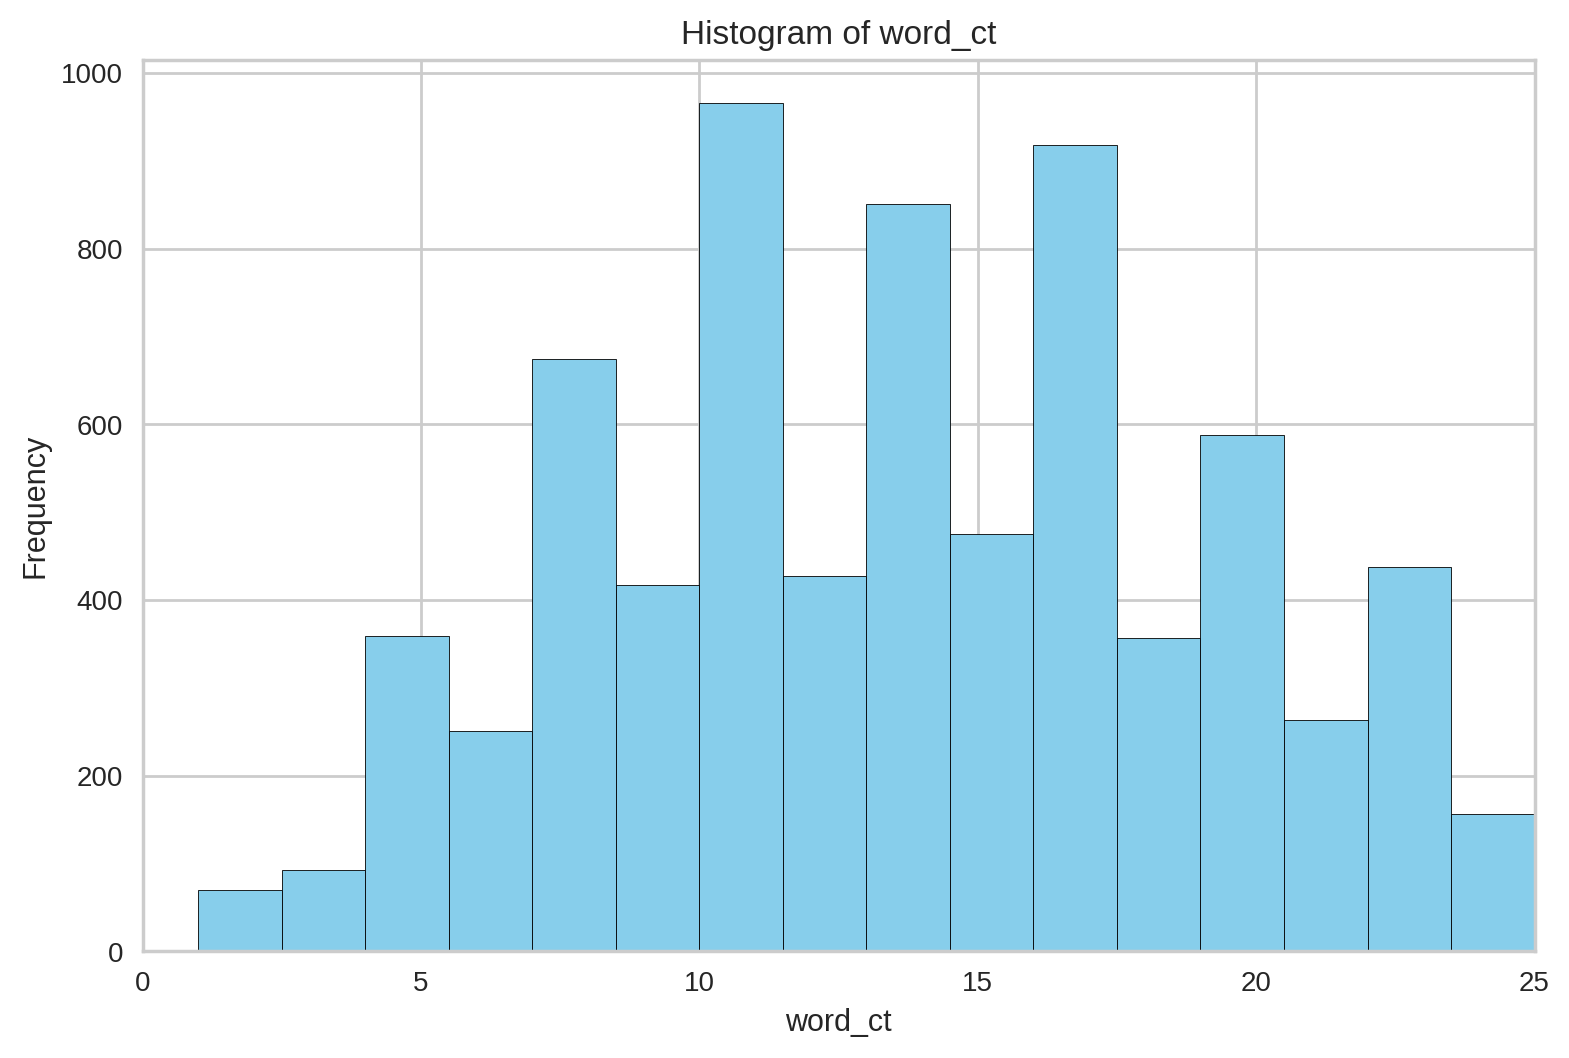

In [ ]:
#Plotting histogram of word count
num_of_words(df2, 'text')
df2['word_ct'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of word_ct')
plt.xlabel('word_ct')
plt.ylabel('Frequency')
plt.xlim(0, 25)
plt.show()

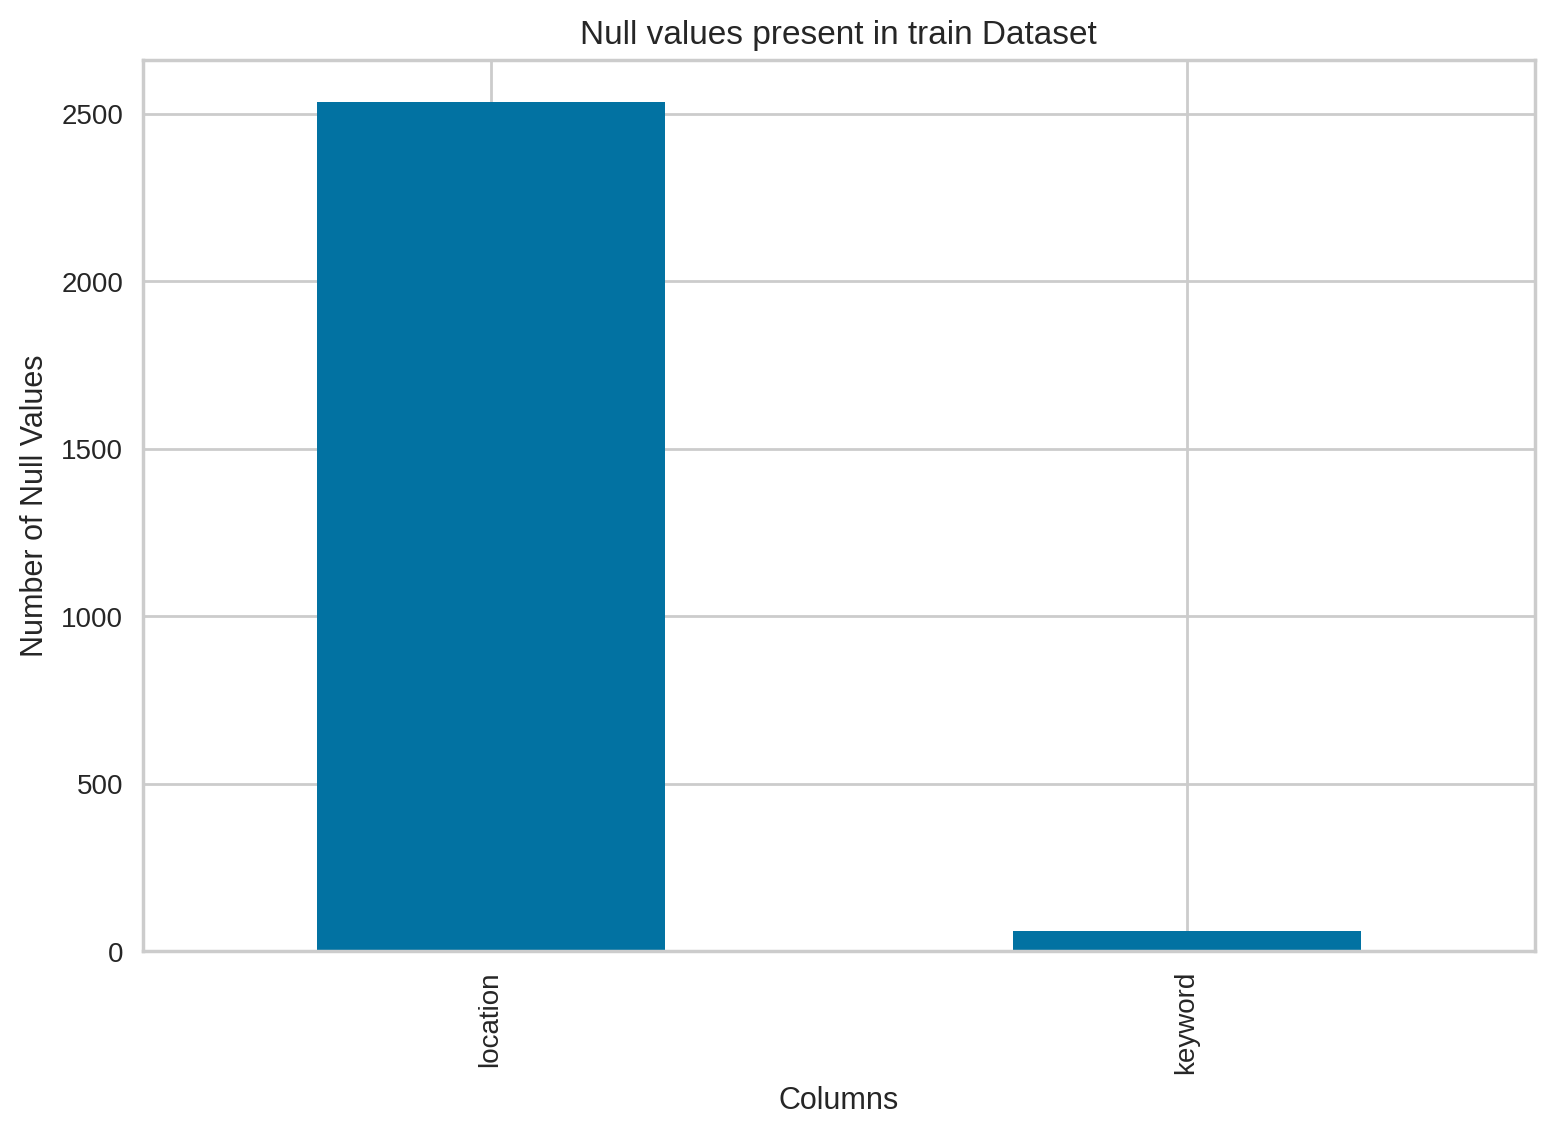

In [ ]:
#Checking null values
missing = df2.isnull().sum()
missing_values = missing[missing > 0].sort_values(ascending=False)

plt.figure()
missing_values.plot(kind='bar')
plt.title('Null values present in train Dataset')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.show()

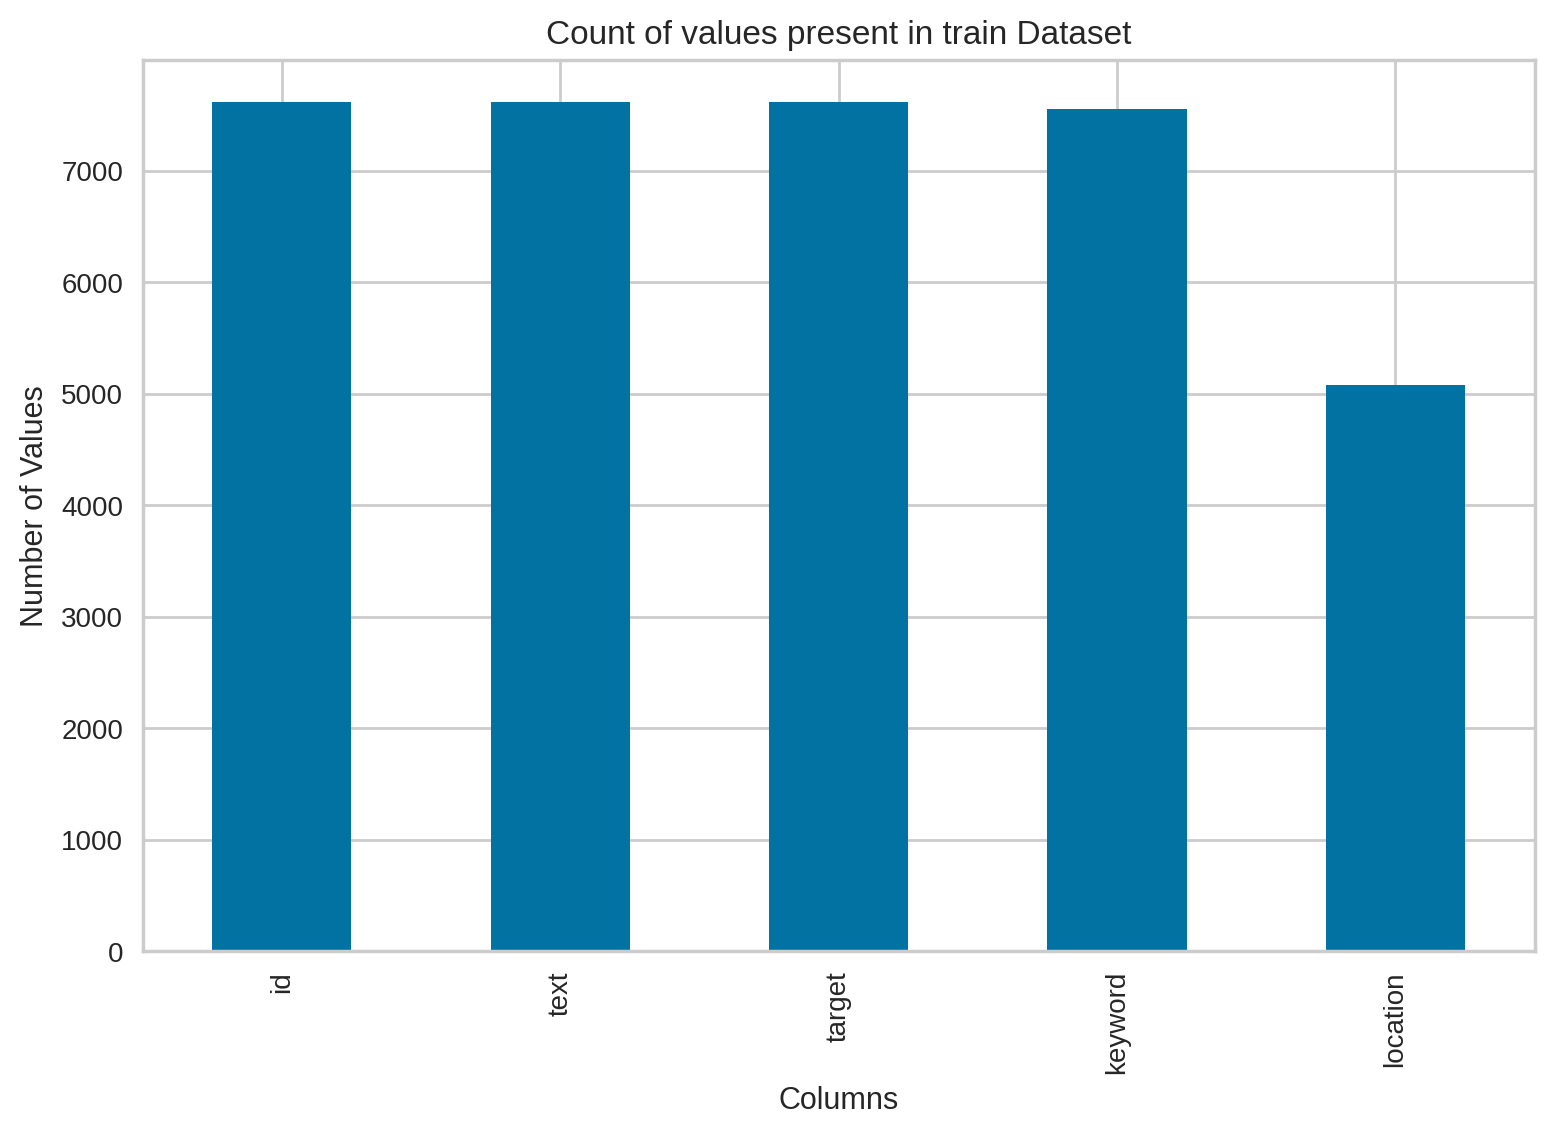

In [ ]:
not_missing = train_df.notnull().sum()
not_missing_values = not_missing[not_missing > 0].sort_values(ascending=False)

plt.figure()
not_missing_values.plot(kind='bar')
plt.title('Count of values present in train Dataset')
plt.xlabel('Columns')
plt.ylabel('Number of Values')
plt.show()

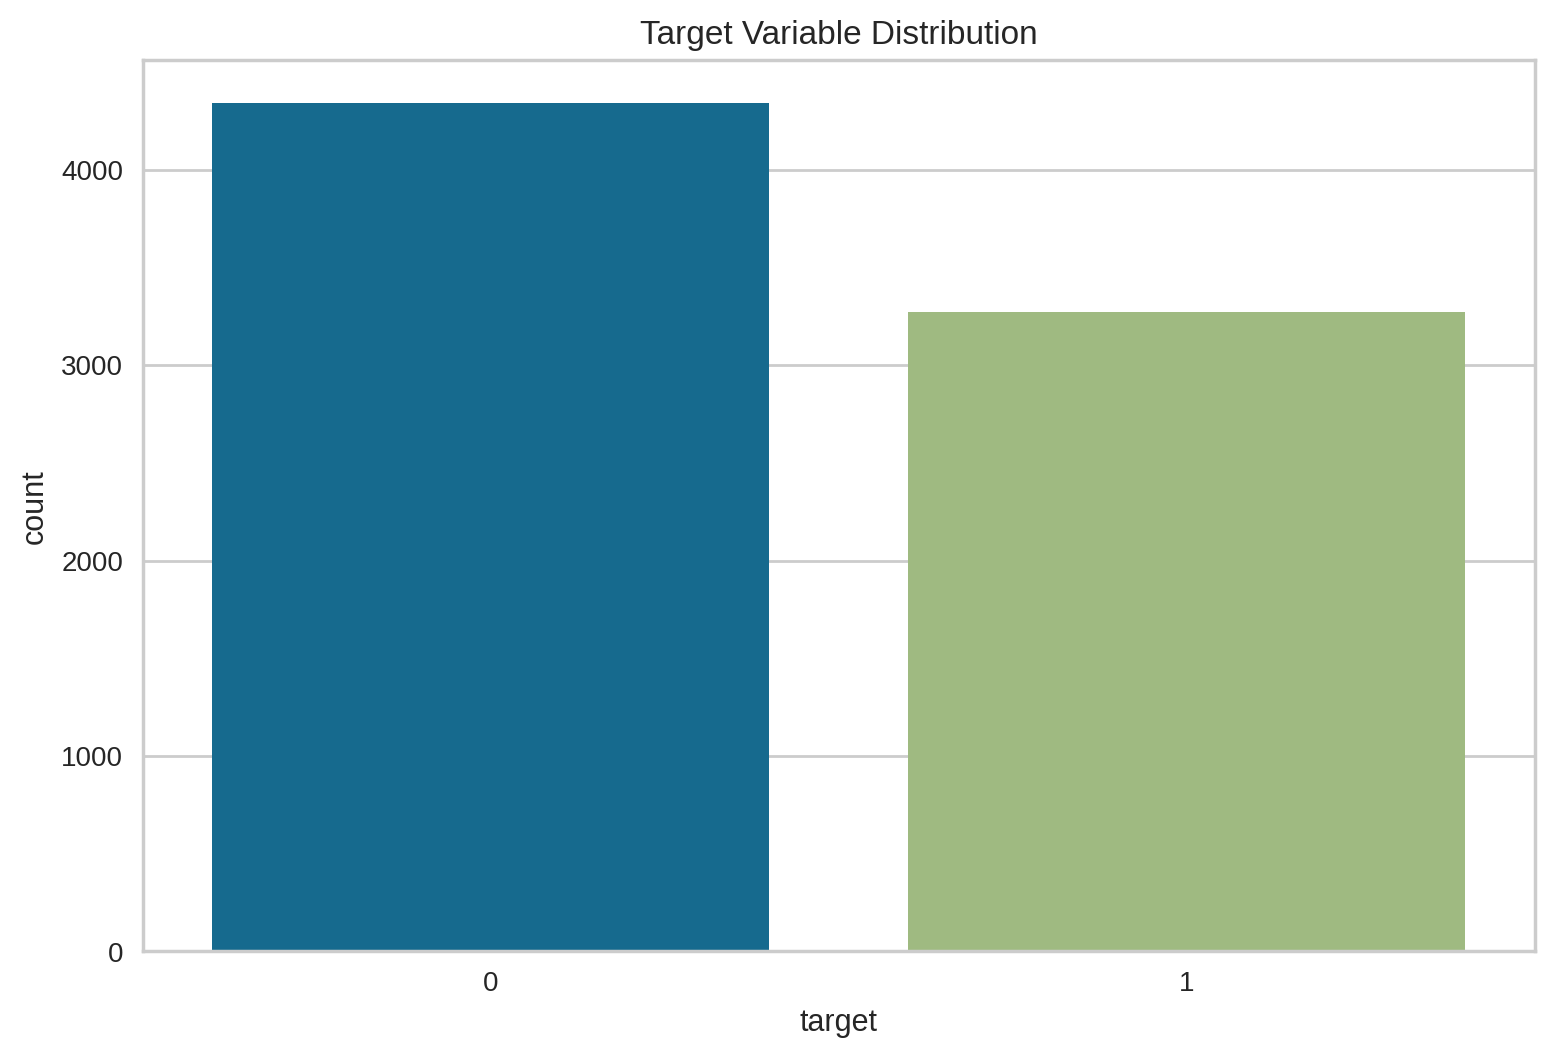

In [ ]:
# visualize the distribution of disaster and non-disaster tweets
sns.countplot(data=df2, x='target')
plt.title('Target Variable Distribution')
plt.show()

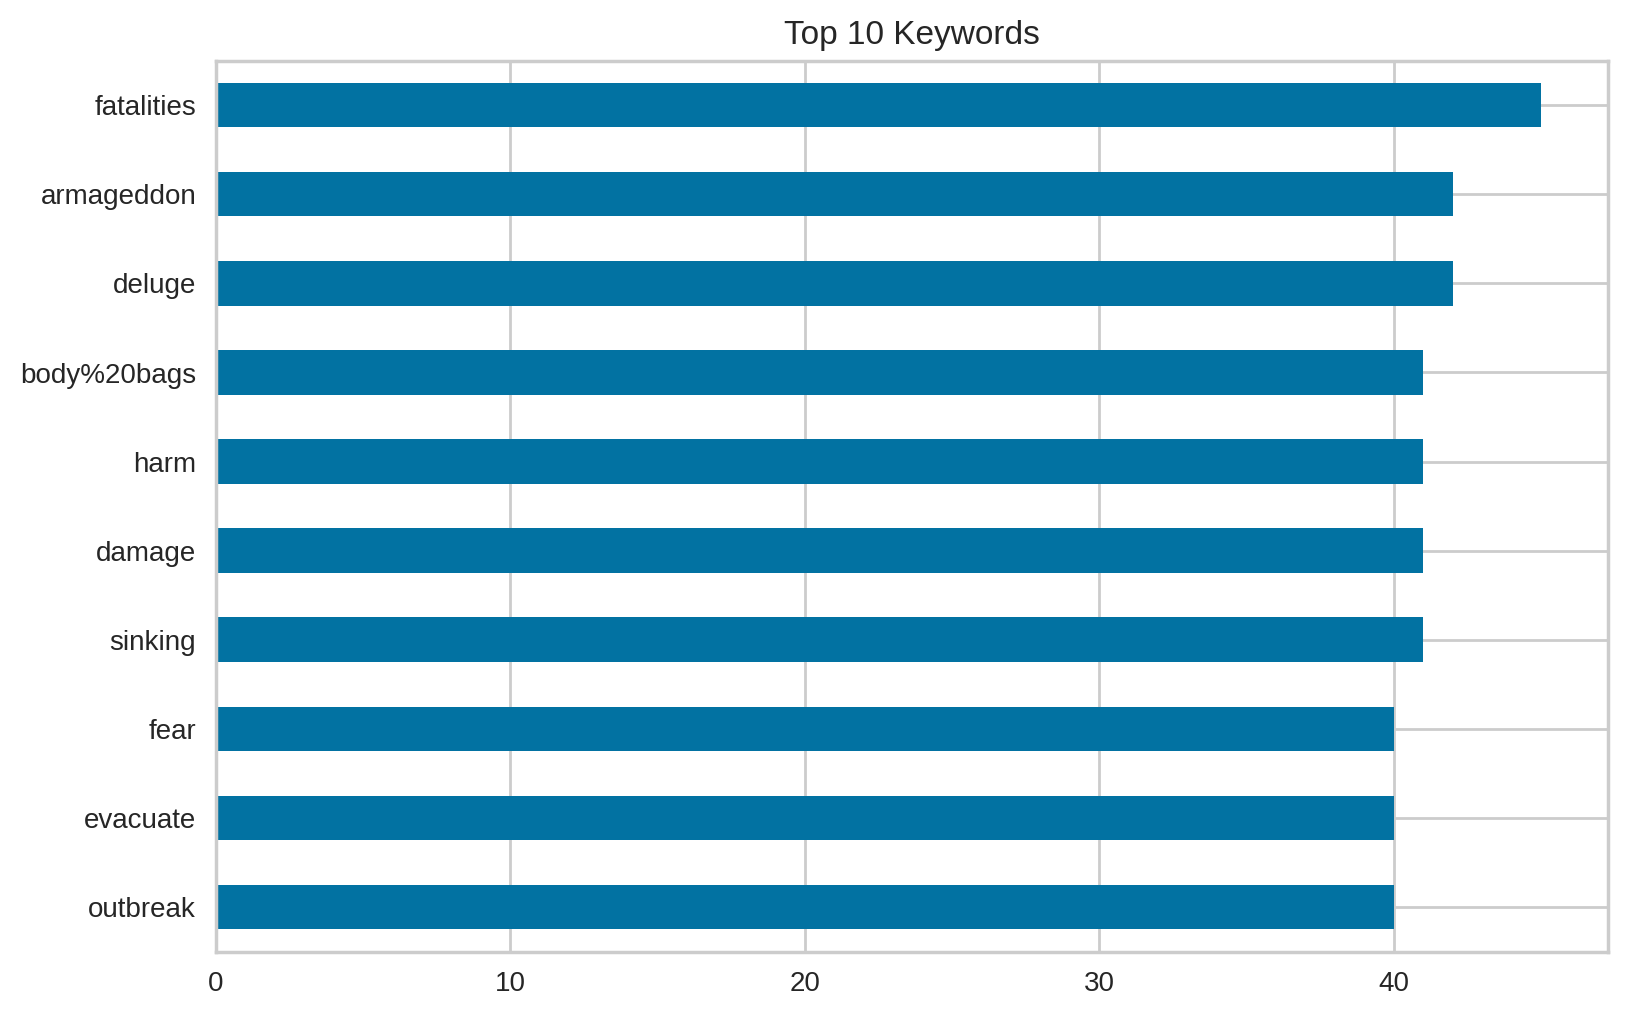

In [ ]:
# visualize the 10 most frequent keywords in the training data 
df2['keyword'].value_counts().head(10).sort_values().plot(kind='barh')
plt.title('Top 10 Keywords')
plt.show()

In [ ]:
# create new dataframe counting the number of times each keyword is associated with the target variable
keyword_target = df2.groupby(['keyword', 'target']).size().unstack(fill_value=0)
keyword_target = keyword_target.sort_values(by=1, ascending=False)

keyword_target.head()

target      0   1
keyword          
derailment  0  39
wreckage    0  39
outbreak    1  39
typhoon     1  37
debris      0  37

In [ ]:
keyword_target_0 = keyword_target.sort_values(by=0, ascending=False)
keyword_target_0.head()

target        0  1
keyword           
body%20bags  40  1
armageddon   37  5
harm         37  4
wrecked      36  3
deluge       36  6

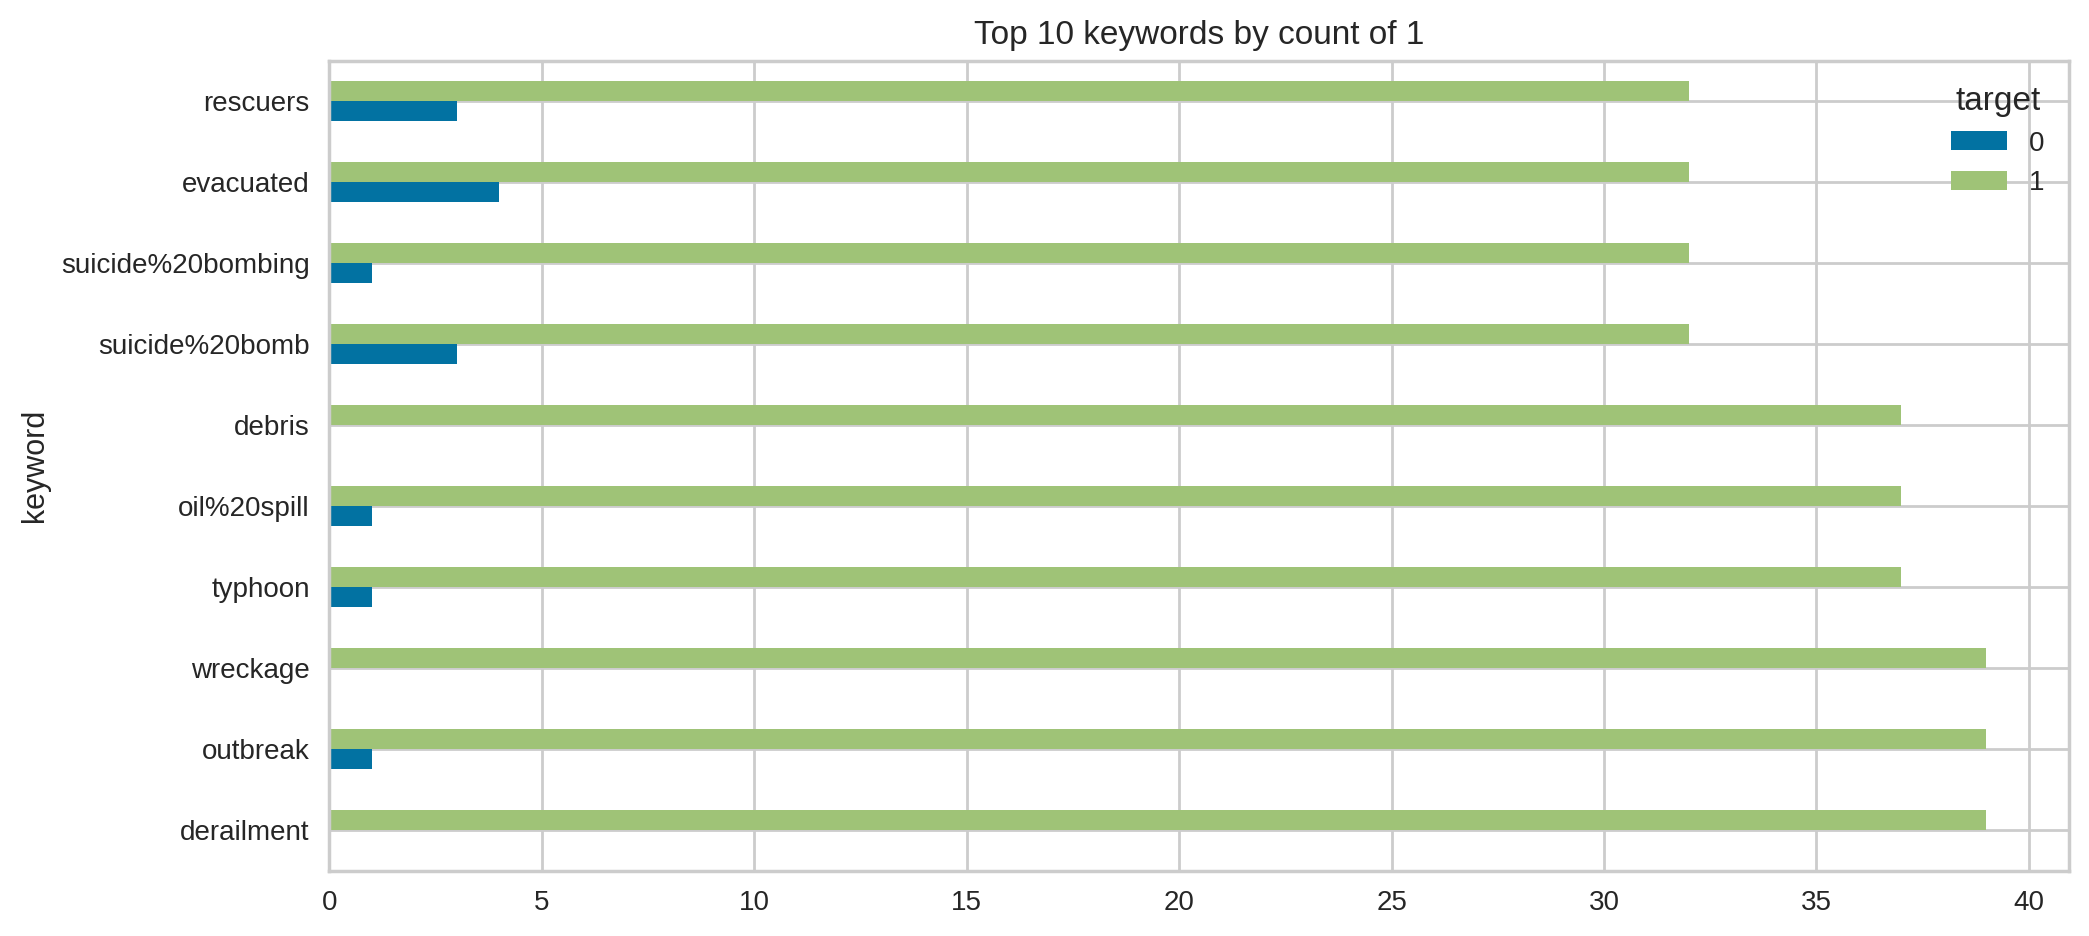

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# Sort the keywords by descending order of count of 1
top_keywords = keyword_target.sort_values(by=1, ascending=False).head(10)

# Plot the top 10 keywords by count of 1
top_keywords[[0, 1]].plot(kind='barh', ax=axes)
axes.set_title('Top 10 keywords by count of 1')

plt.show()

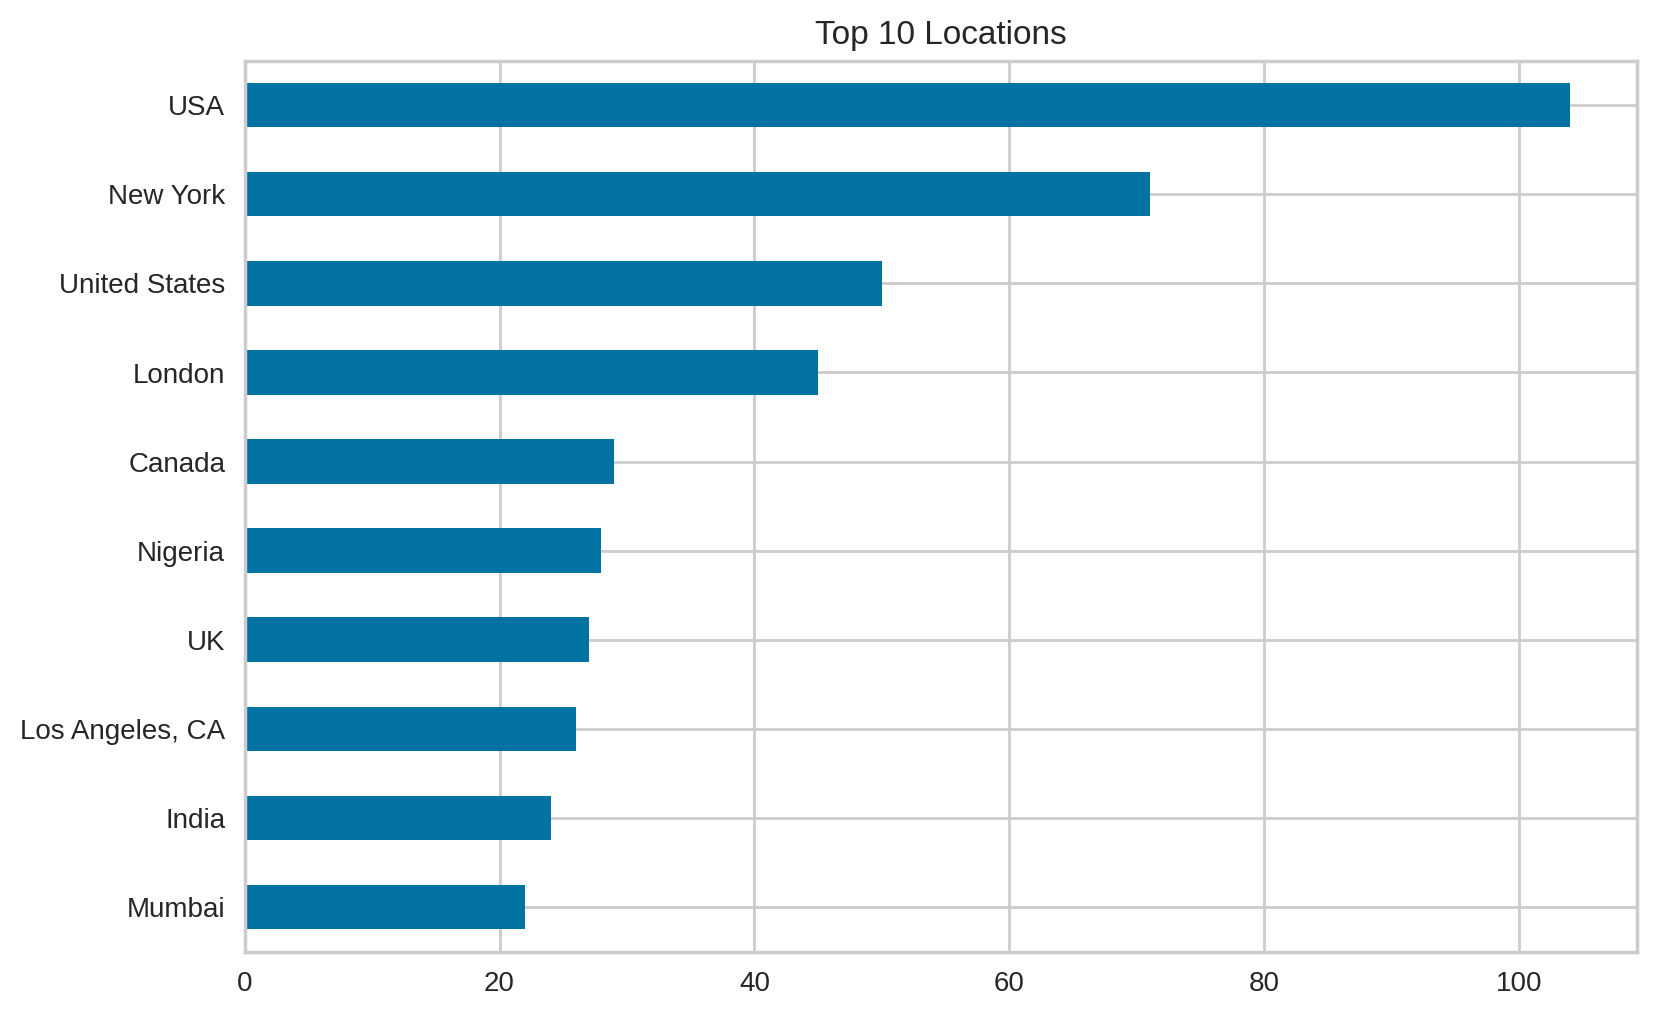

In [ ]:
#plotting Top 10 locations
df2['location'].value_counts().head(10).sort_values().plot(kind='barh')
plt.title('Top 10 Locations')
plt.show()

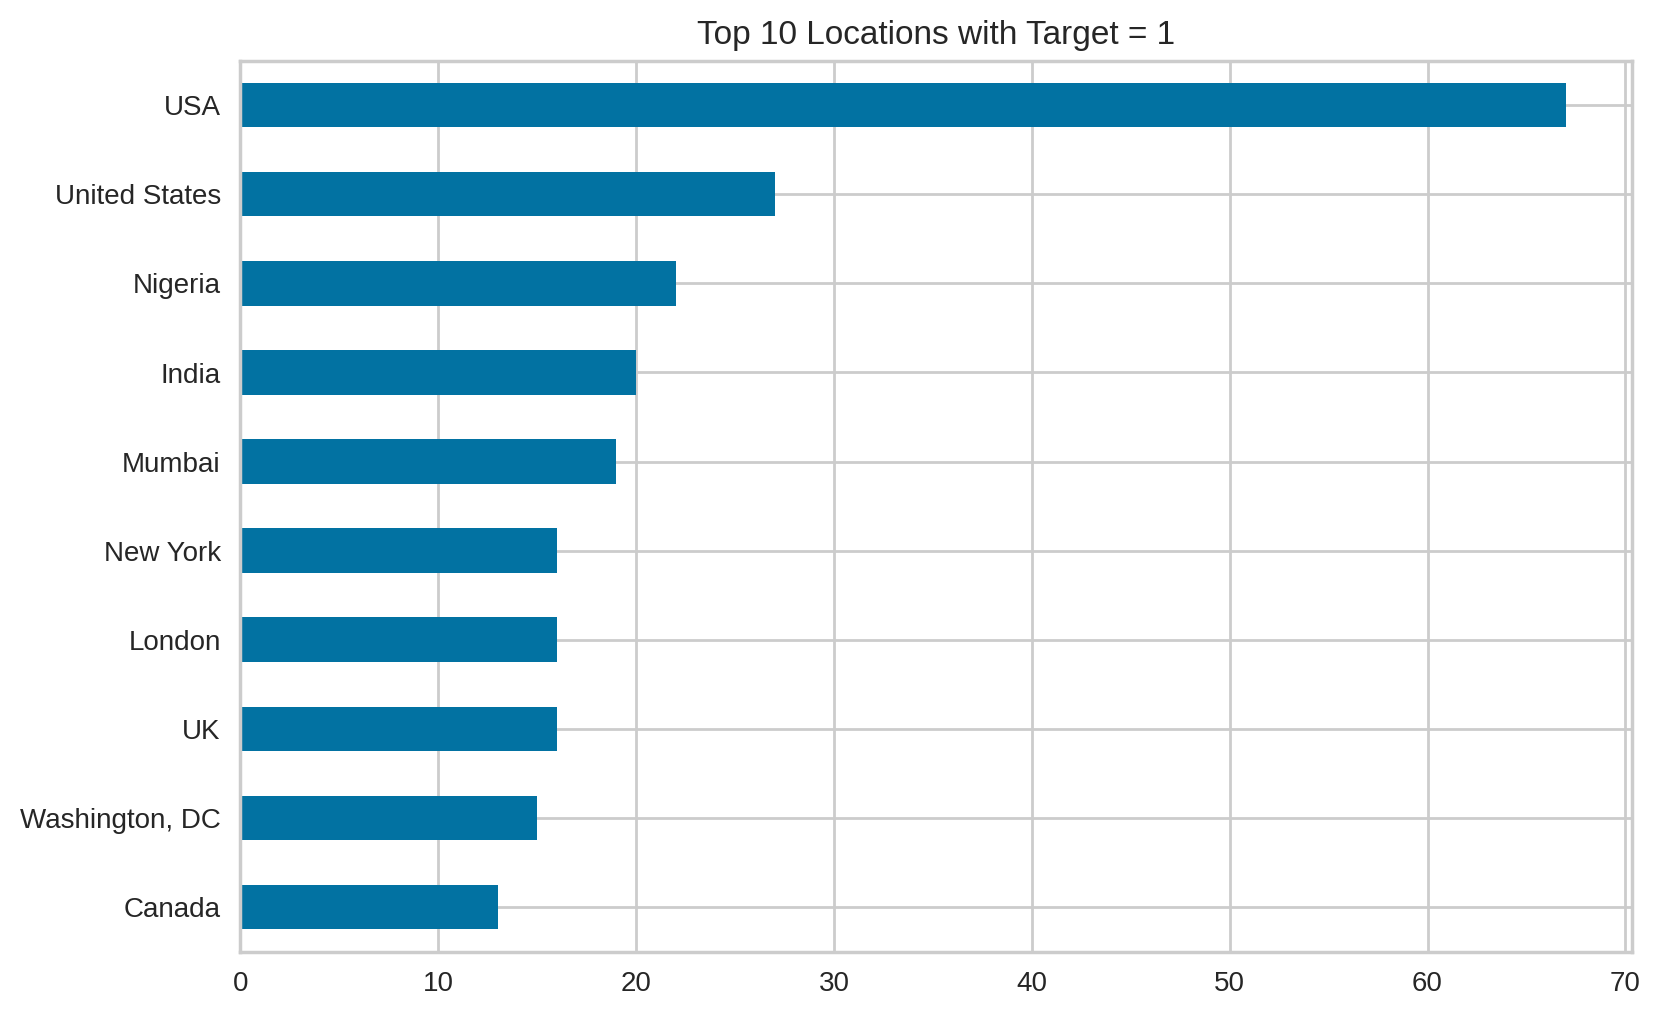

In [ ]:
# Top location with target = 1
df2[df2['target'] == 1]['location'].value_counts().head(10).sort_values().plot(kind='barh')
plt.title('Top 10 Locations with Target = 1')
plt.show()

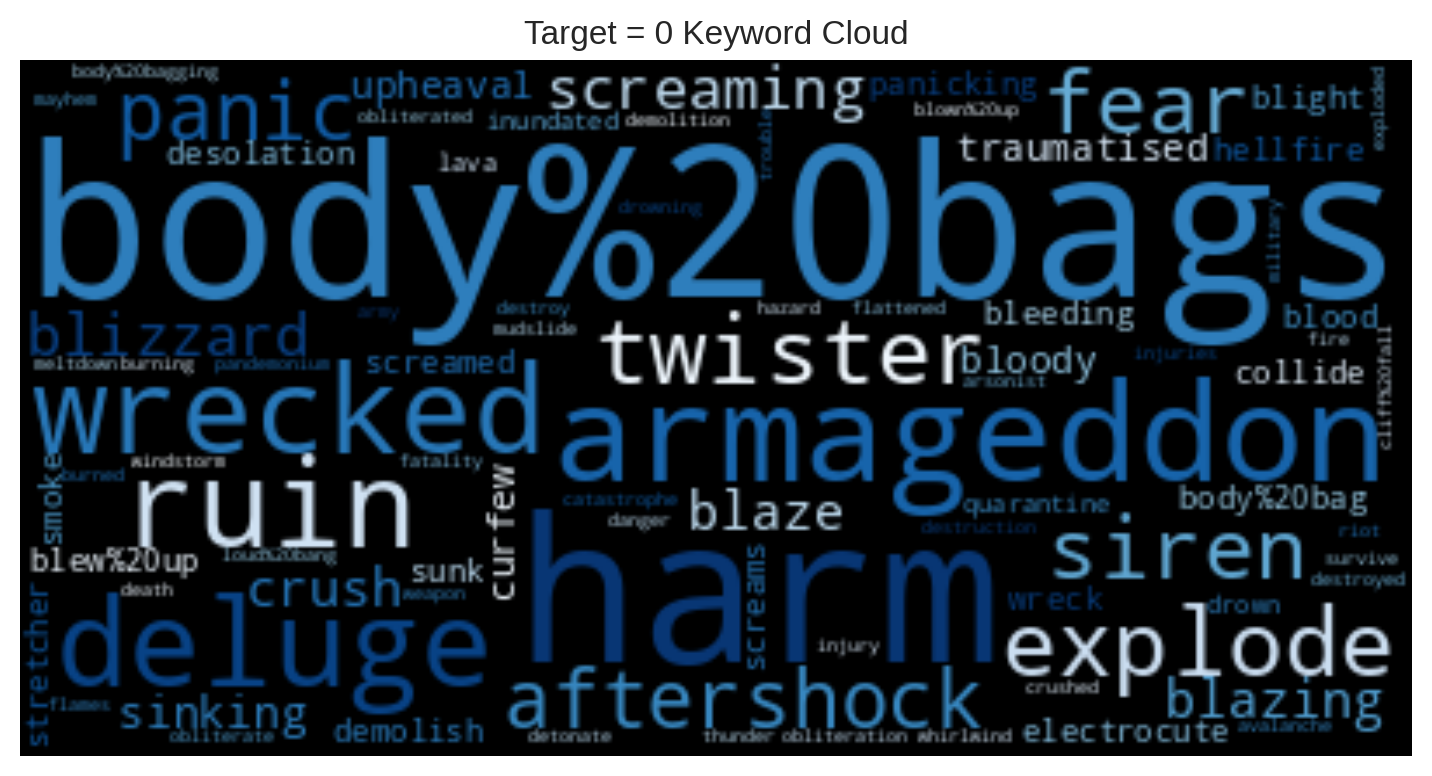

In [ ]:
# Word cloud for keywords in case 0

import matplotlib.pyplot as plt
from wordcloud import WordCloud

Case_0 = df2[df2['target'] == 0]['keyword'].value_counts().to_dict()
wordcloud_0 = WordCloud(colormap='Blues', max_font_size=60, font_step=2).generate_from_frequencies(Case_0)

plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title('Target = 0 Keyword Cloud')

plt.show()

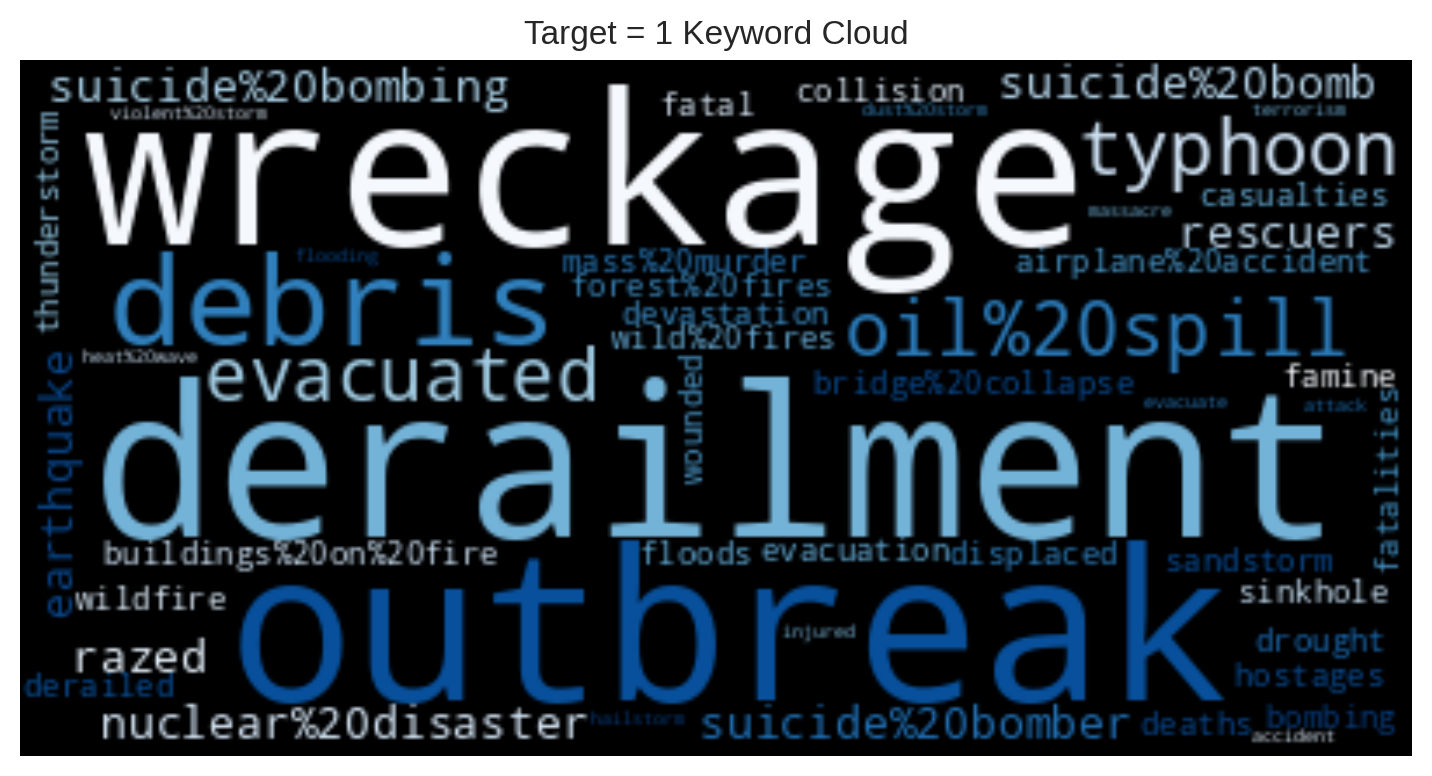

In [ ]:
# Word cloud for keywords in case 1
Case_1 = df2[df2['target'] == 1]['keyword'].value_counts().to_dict()
wordcloud_1 = WordCloud(colormap='Blues', max_font_size=60, font_step=2).generate_from_frequencies(Case_1)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title('Target = 1 Keyword Cloud')

plt.show()

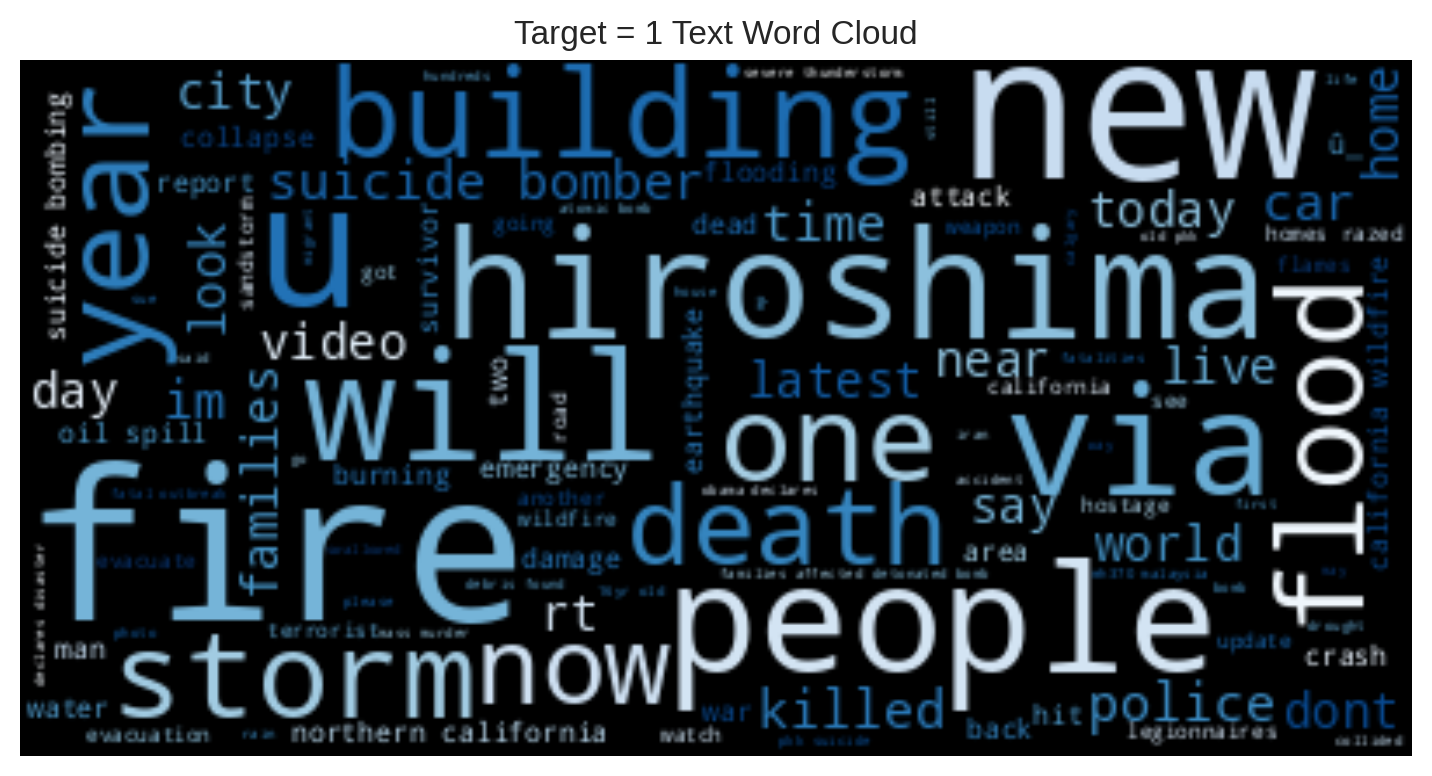

In [ ]:
text_case_1 = ' '.join(df2[df2['target'] == 1]['text'])
wordcloud_case_1 = WordCloud(colormap='Blues', max_font_size=60, font_step=2).generate(text_case_1)
plt.imshow(wordcloud_case_1, interpolation='bilinear')
plt.axis("off")
plt.title('Target = 1 Text Word Cloud')

plt.show()

#### Model Preparation

In [ ]:
df_train_text=df2.text
df_test_text=df3.text
df_train_labels=df2.target

In [ ]:
#creating training and validation splits
TRAINING_SPLIT = 0.8

def train_val_split(texts, labels, training_split):
    
    train_size = int(len(texts)*training_split)
    
    train_texts = texts[:train_size]
    train_labels = labels[:train_size]
    
    validation_texts = texts[train_size:]
    validation_labels = labels[train_size:]
    
    return train_texts, validation_texts, train_labels, validation_labels

train_texts, val_texts, train_labels, val_labels = train_val_split(df_train_text, df_train_labels, TRAINING_SPLIT)

In [ ]:
#Hyperparameters
NUM_WORDS = 10000
OOV_TOKEN = "<OOV>"
MAXLEN = 120
PADDING = 'post'
EMBEDDING_DIM = 128
EPOCHS = 100
BATCH_SIZE = 128

#Tokenizing and padding

def fit_tokenizer(train_texts, num_words, oov_token):
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(train_texts)
    return tokenizer

tokenizer = fit_tokenizer(train_texts, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

def seq_and_pad(texts, tokenizer, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)
    return padded_sequences

train_padded_seq = seq_and_pad(train_texts, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_texts, tokenizer, PADDING, MAXLEN)
    

#### Define an Early Stopping Callback

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20, restore_best_weights=True)

#### Create the Model

In [ ]:
import tensorflow_hub as hub

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow as tf

import tensorflow as tf

def create_model(num_words, embedding_dim, maxlen):
    # Set random seed for reproducibility
    tf.random.set_seed(123)
    
    # Create a Sequential model
    model = tf.keras.Sequential()
    
    # Add an embedding layer with specified dimensions and input length
    model.add(tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen))
    
    # Add a SpatialDropout1D layer to reduce overfitting
    model.add(tf.keras.layers.SpatialDropout1D(0.2))
    
    # Add a Bidirectional LSTM layer with specified dimensions and dropout/recurrent dropout
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    
    # Add a GlobalMaxPooling1D layer to reduce dimensionality
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    
    # Add a Dense layer with specified dimensions and activation function
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    
    # Add a Dropout layer to reduce overfitting
    model.add(tf.keras.layers.Dropout(0.5))
    
    # Add a final Dense layer with one output unit and a sigmoid activation function for binary classification
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    # Compile the model with specified optimizer, loss function, and evaluation metric
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # charlie
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Return the compiled model
    return model

model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
history = model.fit(train_padded_seq, train_labels, epochs=100, batch_size=BATCH_SIZE, validation_data=(val_padded_seq, val_labels), callbacks=[early_stopping])

Epoch 1/100
48/48 [==============================] - 53s 962ms/step - loss: 0.6734 - accuracy: 0.5806 - val_loss: 0.6509 - val_accuracy: 0.5483
Epoch 2/100
48/48 [==============================] - 42s 873ms/step - loss: 0.4981 - accuracy: 0.7880 - val_loss: 0.4688 - val_accuracy: 0.7886
Epoch 3/100
48/48 [==============================] - 62s 1s/step - loss: 0.3186 - accuracy: 0.8824 - val_loss: 0.4591 - val_accuracy: 0.7932
Epoch 4/100
48/48 [==============================] - 42s 875ms/step - loss: 0.2305 - accuracy: 0.9176 - val_loss: 0.5008 - val_accuracy: 0.7708
Epoch 5/100
48/48 [==============================] - 43s 906ms/step - loss: 0.1763 - accuracy: 0.9437 - val_loss: 0.5679 - val_accuracy: 0.7571
Epoch 6/100
48/48 [==============================] - 43s 887ms/step - loss: 0.1372 - accuracy: 0.9522 - val_loss: 0.6737 - val_accuracy: 0.7597
Epoch 7/100
48/48 [==============================] - 42s 869ms/step - loss: 0.1119 - accuracy: 0.9616 - val_loss: 0.7608 - val_accuracy: 0.

#### Inspect Result

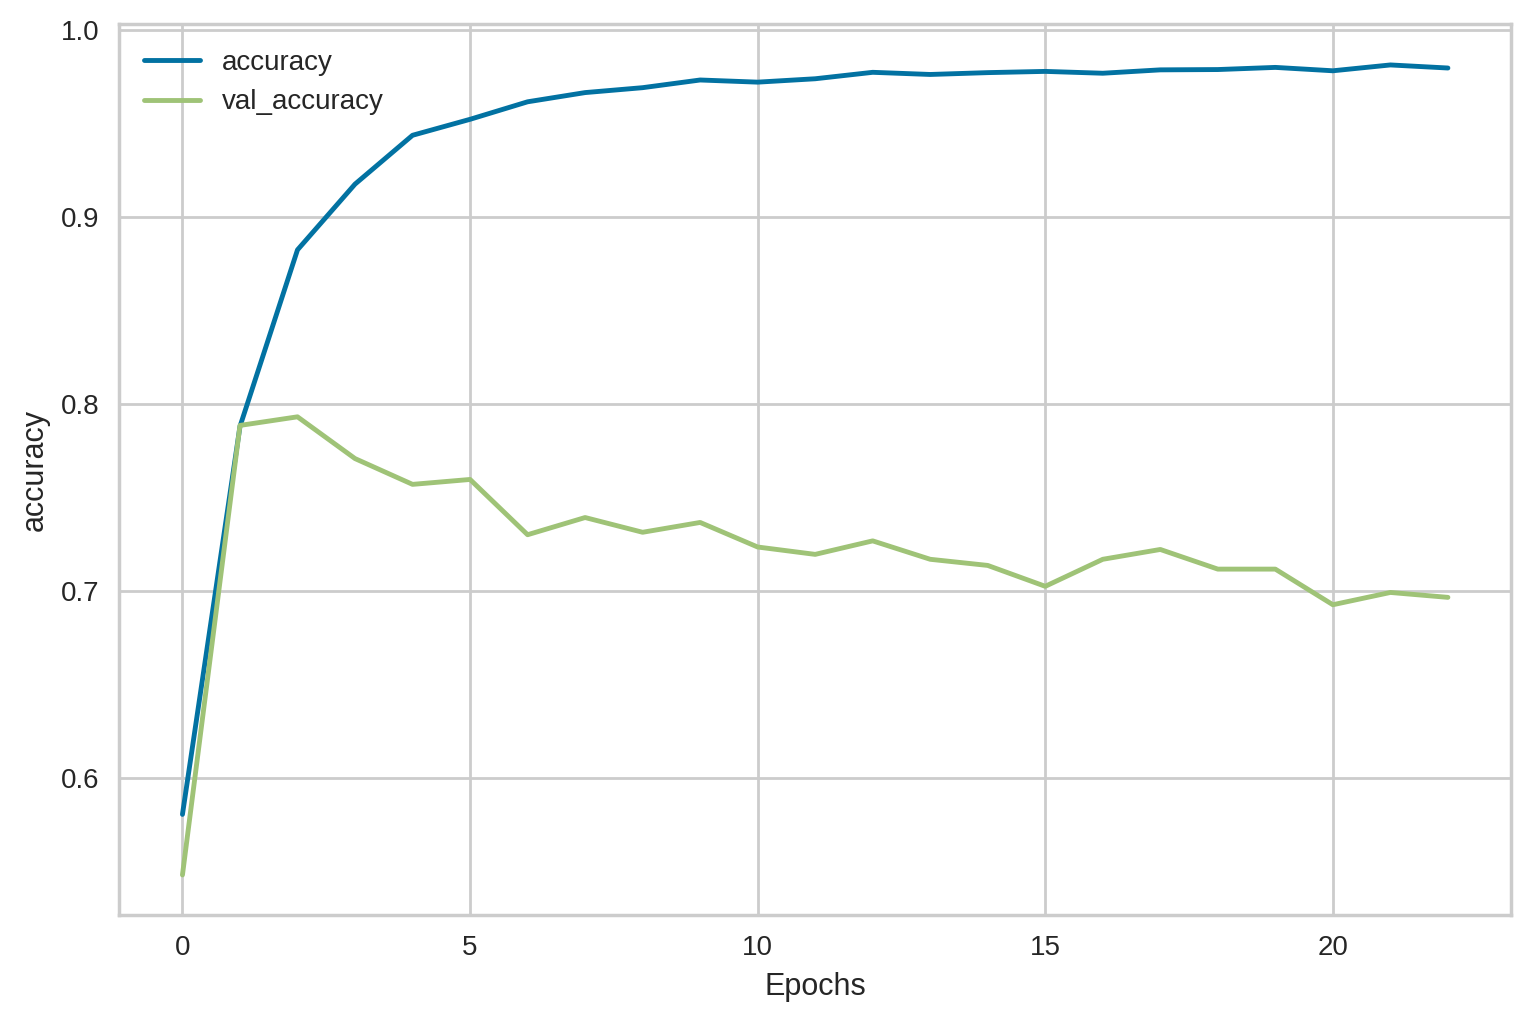

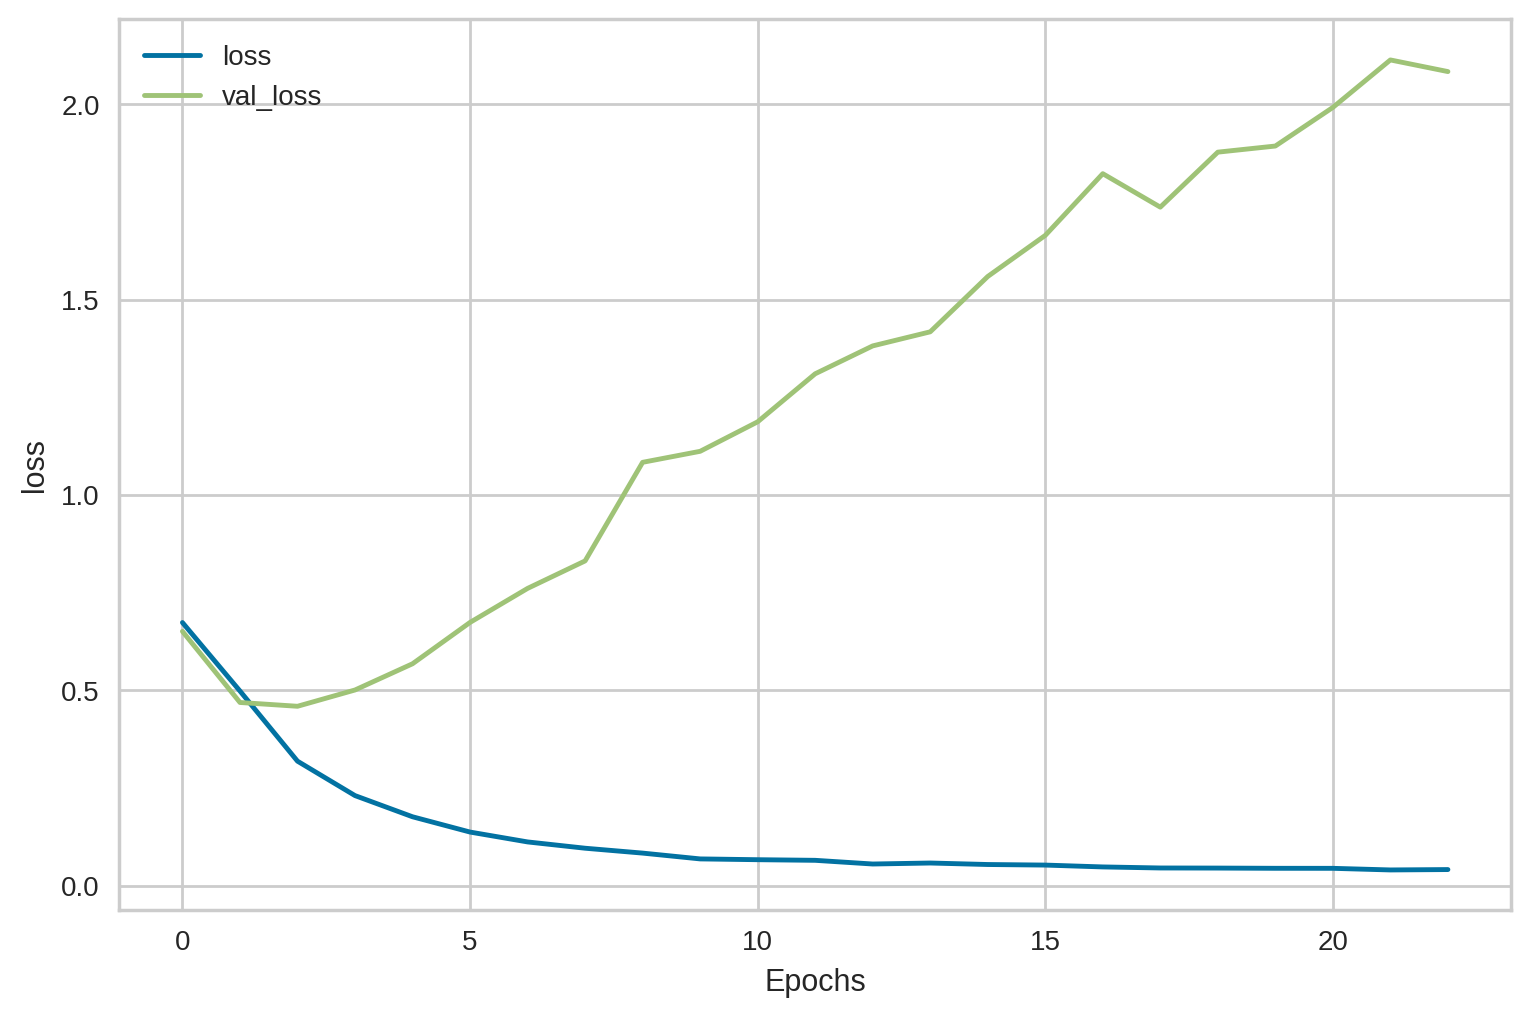

In [ ]:
#Loss and accuracy plots
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()


plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#### Prepare for Submission

In [ ]:
test_padded_seq = seq_and_pad(df_test_text, tokenizer, PADDING, MAXLEN)
df_test_pred = model.predict(test_padded_seq)
sample_submission['target'] = df_test_pred.round().astype(int)
sample_submission.to_csv('submission_team1.csv', index=False)

102/102 [==============================] - 5s 49ms/step
